In [1]:
#Import Packages
import sys
import pickle
import os
import pytz
import datetime
import string
import re
import pandas as pd
import numpy as np
import calendar
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.colors import Normalize
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from windrose import WindroseAxes
import xarray as xr
from pylr2 import regress2
sys.path.append('..')
import funcs.ac_funcs as ac
pd.options.mode.chained_assignment = None
#Autoreload changed local modules
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [2]:
def trim_ds(ds,extent_dict):
    sub_ds =  ds.sel(lat=slice(extent_dict['lat_low'],
                               extent_dict['lat_high']),
                     lon=slice(extent_dict['lon_low'],
                               extent_dict['lon_high']))
    return sub_ds

# Inventories

In [3]:
dataset_extent = {'lon_low':-112.1,
                  'lon_high':-111.7,
                  'lat_low':40.4,
                  'lat_high':41.0} 


## EDGAR

In [4]:
def load_edgar_nc(edgar_path,spec,emi_or_flx,year):
    if spec in ['CH4','CO2']:
        nc_folder_name = f'v8.0_FT2022_GHG_{spec}_{year}_TOTALS_{emi_or_flx}_nc'
        nc_file_name = '_'.join(nc_folder_name.split('_')[:-1]) + '.nc'
    elif spec == 'CO':
        nc_folder_name = f'EDGARv6.1_{spec}_{year}_TOTALS.0.1x0.1'
        nc_file_name = (nc_folder_name) + '.nc'

    nc_fullpath = os.path.join(edgar_path,spec,emi_or_flx,nc_folder_name,nc_file_name)
    try:    
        ds = xr.open_dataset(nc_fullpath)
    except FileNotFoundError as f:
        print(f)
        raise FileNotFoundError(f'There doesnt seem to be data for this configuration:{spec},{emi_or_flx},{year}')
    if spec == 'CO':
        ds = coord_change_360_180(ds)
        ds = ds.rename({'emi_co':'fluxes'})
        ds['fluxes'].attrs['substance'] = 'CO'

    gca_fname = nc_file_name.split('.nc')[0] + '_gca' + '.nc'
    try:
        gca_fullpath = os.path.join(edgar_path,spec,emi_or_flx,nc_folder_name,gca_fname)
        gca_ds = xr.open_dataset(gca_fullpath)
        if spec == 'CO':
            gca_ds = coord_change_360_180(gca_ds)
        ds = add_gca_to_ds(ds,gca_ds)
    except FileNotFoundError:
        print(f'No grid cell area file {gca_fullpath} found. Create with cdo to use. Returning ds without gca')
        return ds

    return ds

def coord_change_360_180(ds):
    return ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon')

def add_gca_to_ds(orig_ds,gca_ds):
    orig_ds['grid_cell_area'] = gca_ds['cell_area']
    return orig_ds


In [5]:
#Load Edgar inventories
edgar_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/EDGAR/'

spec = 'CH4'
year= 2022
emi_or_flx = 'flx'

full_ds = load_edgar_nc(edgar_path,spec,emi_or_flx,year)
sub_ds = trim_ds(full_ds,dataset_extent)
if emi_or_flx == 'flx':
    sub_ds['emissions'] = (sub_ds['grid_cell_area'] * sub_ds['fluxes']) * 86400 * 365 * 1E-3 # [m2] * [kg/m2/s] * [86400s/d] *[365d/y] *[1E-3tonne/kg] = [tonne/yr]
    sub_ds['emissions'].attrs = {'substance':spec,'units':'Tonne'}

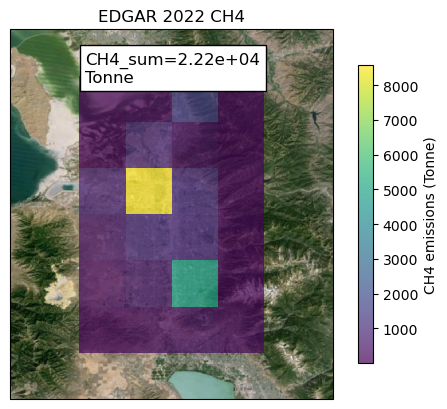

In [6]:
map_extent={'lon_low':-112.25,
            'lon_high':-111.55,
            'lat_low':40.3,
            'lat_high':41.1} 

labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 10.0 # prob have to adjust this
ax.add_image(request,int(scale))
map = sub_ds['emissions'].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
plt.colorbar(map,fraction=0.03,label = f"{spec} emissions ({sub_ds['emissions'].attrs['units']})")

emissions_sum = float(sub_ds['emissions'].sum())
text = f"{spec}_sum={emissions_sum:.2e}\n{sub_ds['emissions'].attrs['units']}"
t1 = fig.text(0.45,0.77,text,fontsize = labsize)
t1.set_bbox(dict(facecolor = 'white'))
plt.title(f"EDGAR {year} {spec}")
plt.show()

## Maasakkers EPA

Paper: https://pubs.acs.org/doi/10.1021/acs.est.3c05138  
Data: https://doi.org/10.5281/zenodo.8367082   
Code: https://github.com/USEPA/GEPA   

Flux values in original nc files are $Flux_{ch4}$ in $[{molec_{CH4}}/{cm^2s}]$. 

Convert flux values to emissions values by $Emission_{ch4} = Flux_{ch4} * grid cell area$  
Where $Emission_{ch4}$ in $[molec_{ch4}/s]$

**CONVERSION to g/yr**   

$Emissions_{ch4} [g/year] = Emissions_{ch4} [molec_{ch4}/s] * Conversion factor $

$Conversion factor = 1/6.022x10^23 [mole/molec_{ch4}] * 16.04 [g_{ch4}/mole] * 86400 [s/day] * y [days/year] $

The number of days per year (y) depends on whether the given year is a leap year. 


In [27]:
def load_epa_nc(path,year):
    fname = f'Express_Extension_Gridded_GHGI_Methane_v2_{year}.nc'
    ds = xr.open_dataset(os.path.join(path,fname))
    name_map = {k: k.replace('emi','flx') for k in ds} #in the nc file, the data variables are names "emi..." which is confusing as they are fluxes. so rename to flx...
    ds = ds.rename(name_map)
    return ds

In [36]:
#Load the Maasakkers data
epa_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/Maasakkers'
year = 2020

epa_full = load_epa_nc(epa_path,year)
epa_subset = trim_ds(epa_full,dataset_extent).sum(dim="time",keep_attrs = True)

In [37]:
#Sum variables
data_variables = list(epa_subset.keys()) #all of the vars in the nc file
emi_variables = [var for var in data_variables if var != 'grid_cell_area'] #drop the grid cell area from the variables list so we can sum
og_units = epa_subset[emi_variables[0]].attrs['units']
for emi_var in emi_variables: #check to make sure the units are the same on all of the emissions variables
    if epa_subset[emi_var].attrs['units'] != og_units:
        raise ValueError(f'The units are different in {emi_var}, so you shouldnt sum')
epa_subset['flx_ch4_sum'] = epa_subset[emi_variables].to_array().sum('variable') #sum along the emissions variables
epa_subset['flx_ch4_sum'].attrs = {'units':og_units} #add the units

#convert flux units to emissions units
# emissions[tonne/yr] = grid_cell_area[cm2] * flx_ch4[molec/cm2/s] * (1/6.022E23)[mol/molec] * 16.04[gch4/mol] * 86400[s/d] * 365[d/y] * 1E-6[tonne/g]
epa_subset['emissions'] = (epa_subset['grid_cell_area']*epa_subset['flx_ch4_sum'])*(1/6.022E23)*16.04*86400*365*1E-6  #multiply the sums by the grid cell area
epa_subset['emissions'].attrs['units'] = 'Tonnes'


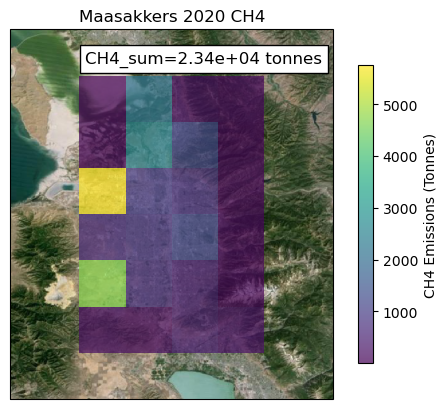

In [38]:
labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure()
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 10.0 # prob have to adjust this
ax.add_image(request,int(scale))

map = epa_subset['emissions'].plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False)
plt.colorbar(map,fraction=0.03,label = f'CH4 Emissions (Tonnes)')

tot_emissions_ch4_tonne = epa_subset['emissions'].sum()
text = f'CH4_sum={tot_emissions_ch4_tonne:.2e} tonnes'
t1 = fig.text(0.45,0.81,text,fontsize = labsize)
t1.set_bbox(dict(facecolor = 'white'))

plt.title(f"Maasakkers {year} CH4")
plt.show()

## NOAA CSL

In [ ]:
def get_satsunwkd(year,month):
    '''Gets the number of saturdays, sundays and weekdays in a given month+year
    
    Args:
    year (int) : the year
    month (int) : the month, as an integer
    
    Returns:
    sat_count (int) : number of saturdays
    sun_count (int) : number of sundays
    wkd_count (int) : number of weekdays
    '''

    num_days_in_month = calendar.monthrange(year,month)[1]
    month_str = f'{month:02d}'

    dow_ints = list(pd.date_range(start=f'{year}-{month_str}-01',end=f'{year}-{month_str}-{num_days_in_month}').weekday)
    sat_count = len([ dow for dow in dow_ints if dow == 5 ])
    sun_count = len([ dow for dow in dow_ints if dow == 6 ])
    wkd_count = len([ dow for dow in dow_ints if dow < 5 ])
    return sat_count,sun_count,wkd_count

In [100]:
csl_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/NOAA_CSL'
year = 2019
month = 1
month_str = f'{month:02d}'

day_type = 'WKD'
full_fname = os.path.join(csl_path,f'{day_type}_nc',f'CO2_{day_type}_{year}_{month_str}_NOAA_CSL_SLV_lon.lat.nc')
csl_xr = xr.open_dataset(full_fname)
csl_xr = trim_ds(csl_xr,dataset_extent)
csl_xr = csl_xr * 3600
csl_xr = csl_xr.sum(dim='hour_UTC')


In [101]:
csl_xr['co2_sum'] = csl_xr[list(csl_xr.keys())].to_array().sum('variable') #sum along the emissions variables

In [108]:
#co2 sum is in umol/m2/d. therefore:
# [tonne/yr] = [umol/m2/d] * 1E-6 [mol/umol] * 365 [d/y] * 44 [g/mol] * 1E-6 [tonne/g] * 2259838224 [m2]
(csl_xr['co2_sum']* 2252456065.6/(40*60) * 1E-6 * 365 * 44 * 1E-6).sum()

<xarray.DataArray 'co2_sum' ()>
array(12033730., dtype=float32)

In [76]:
csl_xr['co2_sum'].mean() / 1E6 * 365 * 16 /1E6 * 2259838224

<xarray.DataArray 'co2_sum' ()>
array(4390243.59791448)

In [ ]:
csl_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/inventories/NOAA_CSL'
year = 2019
month = 1
month_str = f'{month:02d}'

day_type = 'WKD'
full_fname = os.path.join(csl_path,f'{day_type}_nc',f'CO2_{day_type}_{year}_{month_str}_NOAA_CSL_SLV_lon.lat.nc')
csl_xr = xr.open_dataset(full_fname)
csl_xr = trim_ds(csl_xr,dataset_extent)
csl_xr = csl_xr * 60 * 60
csl_xr = csl_xr.sum(dim='hour_UTC')
#csl_xr = csl_xr *86400
# summed_csl = xr.full_like(csl_xr['CO2_EGU_point'],0)
# for data_var in list(csl_xr.data_vars):
#     summed_csl = summed_csl + csl_xr[data_var]

# summed_csl.mean() #* 86400 / 1E6 * 365 * 16 /1E6 * 2259838224 #/ 1E6 * 365 * 16 /1E6 * 2259838224

In [ ]:
csl_xr.sum()

In [ ]:
# Load CO2 csl for weekday in jan
co2_wkd_csl = xr.open_dataset('/uufs/chpc.utah.edu/common/home/lin-group10/HKH/CLS_NOAA_Emissions/Emission_Eval/NCDF_Grid_SLV/WKD_nc/CO2_WKD_2019_01_NOAA_CSL_SLV_lon.lat.nc')
co2_wkd_csl = trim_ds(co2_wkd_csl,dataset_extent)
co2_wkd_csl_hour = co2_wkd_csl*3600
co2_csl_timesum = co2_wkd_csl_hour.sum(dim='hour_UTC')
summed_csl_da = xr.full_like(co2_csl_timesum['CO2_EGU_point'],0)
for data_var in list(co2_csl_timesum.data_vars):
    summed_csl_da = summed_csl_da + co2_csl_timesum[data_var]

In [ ]:
co2_csl_timemean = co2_wkd_csl.mean(dim='hour_UTC')
summed_csl_da = xr.full_like(co2_csl_timemean['CO2_EGU_point'],0)
for data_var in list(co2_csl_timemean.data_vars):
    summed_csl_da = summed_csl_da + co2_csl_timemean[data_var]

In [ ]:
summed_csl_da.mean() 

In [ ]:
x = 0
for data_var in list(co2_csl_timemean.data_vars):
    x+= float(co2_csl_timemean[data_var].mean())
x * 86400 / 1E6 * 365 * 16 /1E6 * 2259838224


In [ ]:
x

In [ ]:
summed_csl_da.mean()

In [ ]:
#Plot it
labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_low'],map_extent['lon_high'],map_extent['lat_low'],map_extent['lat_high']],crs=proj)
request = cimgt.GoogleTiles(style='satellite')
scale = 9.0 # prob have to adjust this
ax.add_image(request,int(scale))

map = summed_csl_da.plot.pcolormesh('lon','lat',ax = ax,alpha=0.7,cmap='viridis',add_colorbar=False,vmax = 2000000)
plt.colorbar(map,fraction=0.03,label ='CO2 Flux umol/s/m2')
plt.show()